In [1]:
from lxml import etree, objectify 
import codecs
import networkx as nx
import math

def compute_length(a,b):
    R = 6371 # средний радиус Земли
    return math.acos(math.sin(a[0]*math.pi/180)*math.sin(b[0]*math.pi/180) + math.cos(a[0]*math.pi/180)\
                     *math.cos(b[0]*math.pi/180)*math.cos((a[1]-b[1])*math.pi/180)) * R

xml = codecs.open('map2.xml', "r", "utf-8").read()
utf8_parser = objectify.makeparser(encoding='utf-8')
root = objectify.fromstring(xml.encode('utf-8'), parser=utf8_parser)

G = nx.Graph()
ends = set()
for lul in root.getchildren():
    if lul.tag == 'way' and 'highway' in [child.attrib.get('k') for child in lul.getchildren() if child.tag == 'tag']:
        nds = [nd.attrib.get('ref') for nd in lul.getchildren() if nd.tag == 'nd']
        ends.add(nds[0])
        ends.add(nds[-1])
        for i in range(len(nds)-1):
            G.add_edge(nds[i], nds[i+1])
            
for node in root.getchildren():
    if node.tag == 'node' and node.attrib.get('id') in G.nodes:
        G.nodes[node.attrib.get('id')]['pos'] = [float(node.attrib.get('lat')), float(node.attrib.get('lon'))]
        
for edge in G.edges:
    G.edges[edge]['length'] = compute_length(G.nodes[edge[0]]['pos'], G.nodes[edge[1]]['pos'])
            
d = nx.to_dict_of_lists(G) # список смежности исходного графа
for node, adj_nodes in d.items():
    if len(adj_nodes) == 2 and node not in ends:
        new_length = G.edges[(node, adj_nodes[0])]['length'] + G.edges[(node, adj_nodes[1])]['length']
        G.remove_node(node)
        if (adj_nodes[0], adj_nodes[1]) in G.edges:
            G.edges[(adj_nodes[0], adj_nodes[1])]['length'] = min(new_length, G.edges[(adj_nodes[0], adj_nodes[1])]['length'])
        else:
            G.add_edge(adj_nodes[0], adj_nodes[1], length = new_length)
        d[adj_nodes[0]].remove(node)
        d[adj_nodes[0]].append(adj_nodes[1])
        d[adj_nodes[1]].remove(node)
        d[adj_nodes[1]].append(adj_nodes[0])

In [22]:
adj_list_dict = nx.to_dict_of_lists(G)
adj_list_str = ''
for k, v in adj_list_dict.items():
    adj_list_str += k + ',' + ','.join(v) + '\n'
with open('adjacency_list.csv', 'w') as file:
    file.write(adj_list_str)

In [24]:
list_str = ''
for node in G.nodes:
    list_str += ','.join([node, str(G.nodes[node]['pos'][0]), str(G.nodes[node]['pos'][0])]) + '\n'
with open('coordinates.csv', 'w') as file:
    file.write(list_str)

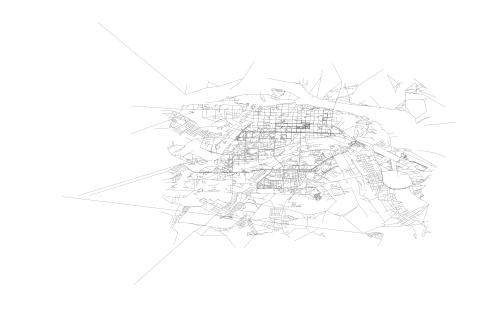

In [3]:
import matplotlib.pyplot as plt

options = {
    'node_color': 'black',
    'node_size': 0, 
    'width': 0.1,
    'pos': nx.get_node_attributes(G, 'pos')
}
nx.draw(G, **options)
plt.axis('off')
#plt.savefig("graph_Kirov.png", dpi=3000)
plt.savefig("graph_Kirov.pdf")

In [4]:
hospitals = {}
for node in root.getchildren():
    if node.tag == 'node' and 'hospital' in [child.attrib.get('v') for child in node.getchildren() if child.tag == 'tag']:
        hospitals[node.attrib.get('id')] = [float(node.attrib.get('lat')), float(node.attrib.get('lon'))]

def euclidean_distance(a,b):
    return ((a[0]-b[0])**2 + (a[1]-b[1])**2) ** 0.5

appr_hos = []
for hospital, pos in hospitals.items():
    min_distance = math.inf
    for node in G.nodes:
        current_distance = euclidean_distance(G.nodes[node]['pos'], pos)
        if current_distance < min_distance:     
            min_distance = current_distance
            temp_id = node
    appr_hos.append(temp_id)
hospitals = appr_hos
print(hospitals)

['429351596', '285921928', '4278976368', '1828912854', '2739242413', '2432486883', '587752723', '5268059855']


In [3]:
import random

def gr_euclidean_distance(a,b):
    (x1,y1) = G.nodes[a]['pos']
    (x2,y2) = G.nodes[b]['pos']
    return ((x1-x2)**2 + (y1-y2)**2) ** 0.5

def gr_manhattan_distance(a,b):
    (x1,y1) = G.nodes[a]['pos']
    (x2,y2) = G.nodes[b]['pos']
    return math.fabs(x1 - x2) + math.fabs(y1 - y2)

def gr_chebyshev_distance(a,b):
    (x1,y1) = G.nodes[a]['pos']
    (x2,y2) = G.nodes[b]['pos']
    return max(math.fabs(x1 - x2), math.fabs(y1 - y2))

def set_default_attributes(G):
    nx.set_edge_attributes(G, 'black', 'color')
    nx.set_node_attributes(G, 'black', 'nd_color')
    nx.set_node_attributes(G, 0, 'nd_size')
    
def set_path(G, path_to_target, target_color='green', edge_color='red'):
    G.nodes[path_to_target['path'][-1]]['nd_color'], G.nodes[path_to_target['path'][-1]]['nd_size'] = target_color, 1
    for i in range(len(path_to_target['path'])-1):
        G.edges[(path_to_target['path'][i], path_to_target['path'][i+1])]['color'] = edge_color

def ways_to_hospitals(G, point_id, hospitals, method, heuristic=None):
    set_default_attributes(G)
    G.nodes[point_id]['nd_size'] = 1

    paths_to_hospitals = {}
    shortest_path_length = math.inf
    shortest_path = []
    
    if method == 'Levit':
        paths_to_hospitals = levit(G, point_id, hospitals, weight='length')
        
    elif method == 'Astar':
        for hospital in hospitals:
            try:
                path_to_hospital = nx.astar_path(G, point_id, hospital, weight='length', heuristic=heuristic)
                path_length = sum(G.edges[(path_to_hospital[i], path_to_hospital[i+1])]['length'] for i in range(len(path_to_hospital)-1))
            except Exception:
                path_to_hospital = [hospital]
                path_length = math.inf
            paths_to_hospitals[hospital] = {'path':path_to_hospital, 'leng':path_length}
    elif method == 'Dijkstra':
        for hospital in hospitals:
            try:
                path_to_hospital = nx.dijkstra_path(G, point_id, hospital, weight='length')
                path_length = sum(G.edges[(path_to_hospital[i], path_to_hospital[i+1])]['length'] for i in range(len(path_to_hospital)-1))
            except Exception:
                path_to_hospital = [hospital]
                path_length = math.inf
            paths_to_hospitals[hospital] = {'path':path_to_hospital, 'leng':path_length}
    
    else:
        print('invalid method') #error
        return
        
    for hospital, path_to_hospital in paths_to_hospitals.items():
        set_path(G, path_to_hospital)
        
        if path_to_hospital['leng'] < shortest_path_length:
            shortest_path_length = path_to_hospital['leng']
            shortest_path = path_to_hospital['path']
    if shortest_path:
        G.nodes[shortest_path[-1]]['nd_color'] = 'blue'
        for i in range(len(shortest_path)-1):
            G.edges[(shortest_path[i], shortest_path[i+1])]['color'] = 'blue'
    return paths_to_hospitals

In [5]:
def levit(G, source, targets, weight):
    adj_list = nx.to_dict_of_lists(G)
    d = {}
    m1,m1s = [],[source]
    for node in G.nodes:
        d[node] = {'leng':math.inf, 'm':3, 'pred':0}
    d[source] = {'leng':0, 'm':2}
        
    while m1 or m1s:
        u = m1.pop(0) if not m1s else m1s.pop(0)
        for v in adj_list[u]:
            new_leng = d[u]['leng'] + G.edges[(u, v)][weight]
            if d[v]['m'] == 3:
                m1.append(v)
                d[v]['m'] = 1
                d[v]['leng'] = new_leng
                d[v]['pred'] = u
            elif (d[v]['leng'] > new_leng) and (d[v]['m'] == 1 or d[v]['m'] == 2):          
                d[v]['leng'] = new_leng
                d[v]['pred'] = u
            elif d[v]['m'] == 0 and d[v]['leng'] > new_leng:
                m1s.append(v)
                d[v]['m'] = 2
                d[v]['leng'] = new_leng
                d[v]['pred'] = u
        d[u]['m'] = 0
    
    res_all = {}
    for target in targets:
        u = target
        res = {'path':[target], 'leng':d[target]['leng']}
        while u != source:
            if not d[u]['pred']:
                break
            res['path'].append(d[u]['pred'])
            u = d[u]['pred']
        res['path'].reverse()
        res_all[target] = res
        
    return res_all   

In [6]:
import time

sam = random.sample(G.nodes, 1)
print(*sam)

start_time = time.time()
for point in sam:
    ways_to_hospitals(G, point, hospitals, 'Dijkstra')
print(time.time() - start_time)

start_time = time.time()
for point in sam:
    ways_to_hospitals(G, point, hospitals, 'Astar', heuristic=gr_euclidean_distance)
print(time.time() - start_time)

start_time = time.time()
for point in sam:
    ways_to_hospitals(G, point, hospitals, 'Astar', heuristic=gr_manhattan_distance)
print(time.time() - start_time)

start_time = time.time()
for point in sam:
    ways_to_hospitals(G, point, hospitals, 'Astar', heuristic=gr_chebyshev_distance)
print(time.time() - start_time)

start_time = time.time()
for point in sam:
    ways_to_hospitals(G, point, hospitals, 'Levit')
print(time.time() - start_time)



2836040964
0.29701709747314453
0.599034309387207
0.5670325756072998
0.5900335311889648
0.4370250701904297


In [18]:
def save_pdf(G, filename, labels_dict = {}):
    options = {
        'node_color': list(nx.get_node_attributes(G, 'nd_color').values()),
        'edge_color': nx.get_edge_attributes(G, 'color').values(),
        'node_size': list(nx.get_node_attributes(G, 'nd_size').values()), 
        'width': 0.1,
        'pos': nx.get_node_attributes(G, 'pos'),
        'labels': labels_dict,
        'font_size': 1
    }

    nx.draw(G, **options)
    plt.axis('off')
    plt.savefig(filename + ".pdf")
    
#save_pdf(G, "path_to_hospital")

58
49


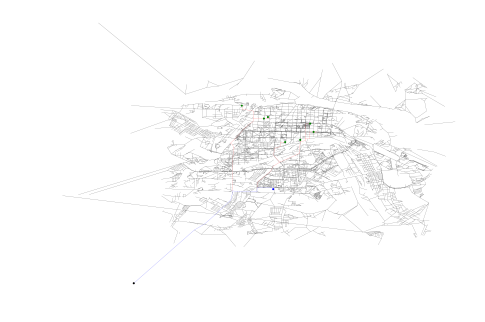

In [55]:
def enter_coordinates():
    x, y = float(input()), float(input())
    current_min = math.inf
    for node in G.nodes:
        dist = euclidean_distance(G.nodes[node]['pos'], (x,y))
        if dist < current_min:
            current_min = dist
            closest_node = node
    return closest_node
        
closest_node = enter_coordinates()
ways_to_hospitals(G, closest_node, hospitals, 'Dijkstra')
save_pdf(G, "path_to_hospital")
# exml: 58.5858335 49.6568659

In [21]:
def path_to_closest_hospital(G, source, hospitals):
    closest_hospital = {'leng':math.inf}
    for hospital in hospitals:
        try:
            path_to_hospital = nx.dijkstra_path(G, source, hospital, weight='length')
            path_length = nx.dijkstra_path_length(G, source, hospital, weight='length')
        except Exception:
            path_to_hospital = [hospital]
            path_length = math.inf
        
        if path_length < closest_hospital['leng']:
            closest_hospital = {'hospital':hospital, 'path':path_to_hospital, 'leng':path_length}
    return closest_hospital

def nearest_neighbour(G, store, hospitals):
    set_default_attributes(G)
    unvisited = hospitals[:]
    order_dict = {}
    current = store
    route_length = 0
    result_path = []

    for i in range(len(hospitals)):
        path_to_next = path_to_closest_hospital(G, current, unvisited)
        set_path(G, path_to_next)
        order_dict[path_to_next['hospital']] = i+1
        result_path += path_to_next['path'][:-1]

        unvisited.remove(path_to_next['hospital'])
        current = path_to_next['hospital']
        route_length += path_to_next['leng']

    path_to_next = path_to_closest_hospital(G, current, [store])
    set_path(G, path_to_next)
    result_path += path_to_next['path']
    route_length += path_to_next['leng']
    G.nodes[store]['nd_color'] = 'black'
    
    return {'path':result_path, 'leng':route_length, 'order_dict':order_dict}

def decreaseTemperature(initialTemperature, i):
    return initialTemperature * 0.1 / i

def isTransition(probability):
    return random.random() <= probability

def generateStateCandidate(state):
    candidate = list(state)
    a = random.randint(0, len(state))
    b = random.randint(0, len(state))
    if a > b:
        a,b = b,a
    subseq = list(reversed(candidate[a:b]))
    for i in range(a,b):
        candidate[i] = subseq[i-a]
    return candidate

def calculateEnergy(G, state):
    energy = 0
    for i in range(len(state)-1):
        energy += G.edges[(state[i], state[i+1])]['length']
    energy += G.edges[(state[-1], state[0])]['length']
    return energy
    

def create_graph(G, objects):
    newG = nx.complete_graph(objects)
    for u, v in newG.edges:
        newG.edges[(u,v)]['length'] = nx.dijkstra_path_length(G, u, v, weight='length')
    return newG

def simulated_annealing_main(G, initialTemperature, endTemperature):
    state = list(G.nodes)
    current_energy = calculateEnergy(G, state)
    t = initialTemperature
    for i in range(10000):
        state_candidate = generateStateCandidate(state)
        candidate_energy = calculateEnergy(G, state_candidate)
        if candidate_energy < current_energy:
            current_energy = candidate_energy
            state = state_candidate
        else:
            p = math.exp((current_energy - candidate_energy) / t)
            if isTransition(p):
                current_energy = candidate_energy
                state = state_candidate
        
        t = decreaseTemperature(initialTemperature, i+1)
        if t < endTemperature:
            break
    return state

def simulated_annealing(G, store, hospitals):
    G2 = create_graph(G, hospitals + [store])
    path = simulated_annealing_main(G2, 10, 0.00001)
    while path[0] != store:
        s = path.pop(0)
        path.append(s)
    path.append(store)
    
    set_default_attributes(G)
    route_length = 0
    result_path =[]
    order_dict = {}
    for i in range(len(path)-1):
        route_length += G2.edges[(path[i], path[i+1])]['length']
        path_to_next = nx.dijkstra_path(G, path[i], path[i+1], weight='length')
        result_path += path_to_next[:-1]
        
        G.nodes[path_to_next[-1]]['nd_color'], G.nodes[path_to_next[-1]]['nd_size'] = 'green', 1
        for i in range(len(path_to_next)-1):
            G.edges[(path_to_next[i], path_to_next[i+1])]['color'] = 'red'
        G.nodes[store]['nd_color'] = 'black'
        
    for i, hospital in enumerate(path[1:-1]):
        order_dict[hospital] = i+1
        
    result_path.append(store)
    
    return {'path':result_path, 'leng':route_length, 'order_dict':order_dict}

In [20]:
for point in random.sample(G.nodes, 10):
    trs1 = nearest_neighbour(G, point, hospitals)
    trs2 = simulated_annealing(G, point, hospitals)
    print(point, trs1['leng'], trs2['leng'])
    #save_pdf(G, "nearest_neighbour", trs1['order_dict'])
    #save_pdf(G, "simulated_annealing", trs2['order_dict'])

2747169762 22.089137416962778 20.2690884563632
1837090092 24.94429540778112 20.97152921924849
3408740507 23.15275854008572 21.619485592805795
934670270 34.13106404109621 32.785368952099354
5268091001 21.772468535697087 19.952419575097508
1934502732 20.967667826020797 19.57259781552499
2527916502 24.091036819168494 22.557763871888568
5271304304 25.033962658058684 24.7059412226663
3637703535 22.734159329931515 22.00331594154492
430865404 20.354741960509173 19.62389857212258


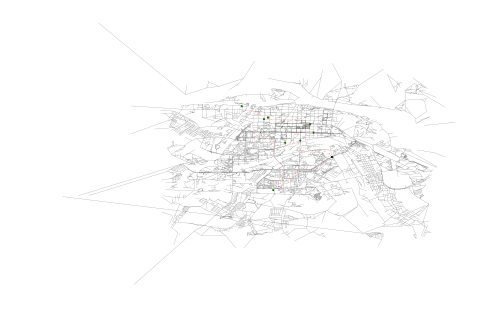

In [61]:
trs1 = nearest_neighbour(G, '2429255625', hospitals)
save_pdf(G, "nearest_neighbour", trs1['order_dict'])

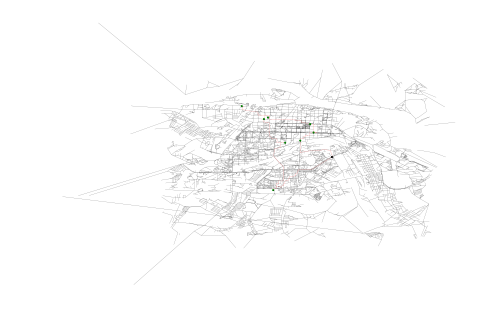

In [60]:
trs1 = simulated_annealing(G, '2429255625', hospitals)
save_pdf(G, "simulated_annealing", trs1['order_dict'])

58.5858335
49.6568659


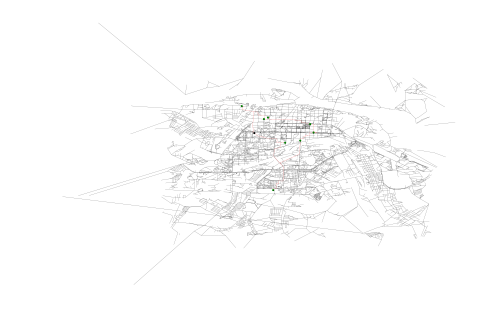

In [63]:
closest_node = enter_coordinates()
trs2 = simulated_annealing(G, closest_node, hospitals)
save_pdf(G, "travelling_salesman", trs2['order_dict'])
# exml: 58.5858335 49.6568659